# Phase 3 Weighted Bagging

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import os
import re
import csv
import codecs
import gensim
import itertools
import numpy as np
import pandas as pd
import operator
import sys

from nltk import ngrams
from collections import Counter
from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from iwillwin.trainer.supervised_trainer import KerasModelTrainer
from iwillwin.data_utils.data_helpers import DataTransformer, DataLoader
from iwillwin.config import dataset_config
from iwillwin.data_utils.feature_engineering import FeatureCreator

from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from nltk import word_tokenize

import seaborn as sns
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
import re
import csv
import codecs
import numpy as np
import pandas as pd
import operator
from os import listdir
from os.path import isfile, join

########################################
## import packages
########################################
import os
import re
import csv
import codecs
import numpy as np
np.random.seed(1337)

import pandas as pd
import operator
import sys

from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from iwillwin.trainer.supervised_trainer import KerasModelTrainer
from iwillwin.data_utils.data_helpers import DataTransformer, DataLoader
from iwillwin.config import dataset_config
from keras.utils import to_categorical

C:\Users\zake7\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.
C:\Users\zake7\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
NB_WORDS, MAX_SEQUENCE_LENGTH = 50000, 50
data_transformer = DataTransformer(max_num_words=NB_WORDS, max_sequence_length=MAX_SEQUENCE_LENGTH, char_level=False,
                                   normalization=True, features_processed=True)
trains_nns, tests_nns, labels = data_transformer.prepare_data(dual=False)
print("Number of unique words", len(data_transformer.tokenizer.index_docs))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zake7\AppData\Local\Temp\jieba.cache
Loading model cost 0.469 seconds.
Prefix dict has been built succesfully.


[DataHelper] Apply normalization on value-type columns


C:\Users\zake7\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Doing preprocessing...
Transforming words to indices...
Shape of data tensor: (320552, 50) (320552, 50)
Shape of label tensor: (320552,)
Preprocessed.
Number of unique words 83265


In [3]:
trains_meta = trains_nns[2]
tests_meta = tests_nns[2]

In [4]:
train_df = pd.read_csv('../data/dataset/train.csv')
test_df = pd.read_csv('../data/dataset/test.csv')

In [5]:
rumor_words = ['辟谣', '谣言', '勿传', '假的']

def is_rumor(text):
    if type(text) != str:
        print(text, type(text))
        return 0
    for rumor_word in rumor_words:
        if rumor_word in text:
            return 1
    return 0

def has_split_symbol(text):
    if type(text) != str:
        return 0
    if '|' in text:
        return 1
    return 0

for df in [train_df, test_df]:
    df['has_|'] = df['title2_zh'].apply(has_split_symbol)
    df['has_rumor_words'] = df['title2_zh'].apply(is_rumor)

nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>


In [6]:
train_has_rumor = train_df.has_rumor_words.values
test_has_rumor = test_df.has_rumor_words.values

trick_trains_features = np.concatenate((trains_nns[2], train_has_rumor.reshape((-1, 1))), axis=1)
trick_tests_features = np.concatenate((tests_nns[2], test_has_rumor.reshape((-1, 1))), axis=1)

In [8]:
oof_file_names = sorted([f for f in listdir('../data/oofs/') if isfile(join('../data/oofs/', f)) and f != '.gitkeep'])
preds_file_names = [name.replace('-Train', '') for name in oof_file_names]

oofs = []
preds = []
for name in oof_file_names:
    oofs.append(pd.read_csv('../data/oofs/' + name))
for name in preds_file_names:
    preds.append(pd.read_csv('../data/output/' + name))    

In [9]:
for i, name in enumerate(oof_file_names):
    print(i, name)
    
trains = pd.DataFrame()
tests = pd.DataFrame()

for i in range(len(oof_file_names)):
    for label_type in ['agreed', 'disagreed', 'unrelated']:
        trains['oofs_{}_{}'.format(i, label_type)] = oofs[i][label_type].values
        tests['oofs_pred{}_{}'.format(i, label_type)] = preds[i][label_type].values

0 3Embedding-3LayersDenseCNN42-NoDrop-NoClassWeighted-NoEM-Train-L0.809633-NB5000.csv
1 3Embedding-3LayersDenseRNN42-Drop01-NoMeta-NoClassWeighted-WithEM-Train-L0.816583-NB5000.csv
2 3Embedding-ESIM-Drop01-NoMeta-NoClassWeighted-NoEM-Train-L0.833565-NB5000.csv
3 WordSGNS-DenseCNN5Layers-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.838202-NB100000.csv
4 WordSGNS-ESIM-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L1.104962-NB100000.csv
5 WordTC-DenseCNN5Layers-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.8440-NB100000.csv
6 WordTC-DenseRNN-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.854586-NB100000.csv
7 WordTC-ESIM-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.374334-NB100000.csv
8 WordTC-Gated4GWindows-NoMeta-3P-NoEM-NoClassWeighted-3Layers-withEM-Train-L0.836860-NB100000.csv


In [10]:
oof_file_names

['3Embedding-3LayersDenseCNN42-NoDrop-NoClassWeighted-NoEM-Train-L0.809633-NB5000.csv',
 '3Embedding-3LayersDenseRNN42-Drop01-NoMeta-NoClassWeighted-WithEM-Train-L0.816583-NB5000.csv',
 '3Embedding-ESIM-Drop01-NoMeta-NoClassWeighted-NoEM-Train-L0.833565-NB5000.csv',
 'WordSGNS-DenseCNN5Layers-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.838202-NB100000.csv',
 'WordSGNS-ESIM-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L1.104962-NB100000.csv',
 'WordTC-DenseCNN5Layers-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.8440-NB100000.csv',
 'WordTC-DenseRNN-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.854586-NB100000.csv',
 'WordTC-ESIM-NoMeta-3P-NoEM-NoClassWeighted-3Layers-Train-L0.374334-NB100000.csv',
 'WordTC-Gated4GWindows-NoMeta-3P-NoEM-NoClassWeighted-3Layers-withEM-Train-L0.836860-NB100000.csv']

In [11]:
unrelated = pd.DataFrame()
agreeds = pd.DataFrame()
disagreeds = pd.DataFrame()

#check_oofs = True
check_oofs = False


if check_oofs:
    for i, oof in enumerate(oofs):
        agreeds['oofs_agreed_{}'.format(i)] = oofs[i]['agreed'].values
        unrelated['oofs_unrelated_{}'.format(i)] = oofs[i]['unrelated'].values
        disagreeds['oofs_disagreeds_{}'.format(i)] = oofs[i]['disagreed'].values
else:
    for i, oof in enumerate(oofs):
        agreeds['oofs_agreed_{}'.format(i)] = preds[i]['agreed'].values
        unrelated['oofs_unrelated_{}'.format(i)] = preds[i]['unrelated'].values
        disagreeds['oofs_disagreeds_{}'.format(i)] = preds[i]['disagreed'].values  

In [12]:
agreeds.corr()

,oofs_agreed_0,oofs_agreed_1,oofs_agreed_2,oofs_agreed_3,oofs_agreed_4,oofs_agreed_5,oofs_agreed_6,oofs_agreed_7,oofs_agreed_8
oofs_agreed_0,1.000000,0.982310,0.976632,0.959797,0.956807,0.961449,0.961597,0.959404,0.962629
oofs_agreed_1,0.982310,1.000000,0.982479,0.958966,0.957473,0.961494,0.961780,0.961639,0.961288
oofs_agreed_2,0.976632,0.982479,1.000000,0.955476,0.959167,0.957512,0.961050,0.963775,0.956841
oofs_agreed_3,0.959797,0.958966,0.955476,1.000000,0.982100,0.977313,0.970090,0.972992,0.973543
oofs_agreed_4,0.956807,0.957473,0.959167,0.982100,1.000000,0.971693,0.972289,0.979278,0.968705
oofs_agreed_5,0.961449,0.961494,0.957512,0.977313,0.971693,1.000000,0.981701,0.981716,0.982047
oofs_agreed_6,0.961597,0.961780,0.961050,0.970090,0.972289,0.981701,1.000000,0.983917,0.982819
oofs_agreed_7,0.959404,0.961639,0.963775,0.972992,0.979278,0.981716,0.983917,1.000000,0.978351
oofs_agreed_8,0.962629,0.961288,0.956841,0.973543,0.968705,0.982047,0.982819,0.978351,1.000000


In [13]:
disagreeds.corr()

,oofs_disagreeds_0,oofs_disagreeds_1,oofs_disagreeds_2,oofs_disagreeds_3,oofs_disagreeds_4,oofs_disagreeds_5,oofs_disagreeds_6,oofs_disagreeds_7,oofs_disagreeds_8
oofs_disagreeds_0,1.000000,0.954897,0.951416,0.912412,0.913741,0.912573,0.916230,0.912694,0.908535
oofs_disagreeds_1,0.954897,1.000000,0.964977,0.920113,0.918646,0.920680,0.921862,0.920311,0.911443
oofs_disagreeds_2,0.951416,0.964977,1.000000,0.919030,0.925045,0.915579,0.923305,0.926555,0.913171
oofs_disagreeds_3,0.912412,0.920113,0.919030,1.000000,0.967334,0.956456,0.945988,0.954167,0.943892
oofs_disagreeds_4,0.913741,0.918646,0.925045,0.967334,1.000000,0.946770,0.944932,0.961943,0.939010
oofs_disagreeds_5,0.912573,0.920680,0.915579,0.956456,0.946770,1.000000,0.965450,0.960278,0.955281
oofs_disagreeds_6,0.916230,0.921862,0.923305,0.945988,0.944932,0.965450,1.000000,0.963620,0.958197
oofs_disagreeds_7,0.912694,0.920311,0.926555,0.954167,0.961943,0.960278,0.963620,1.000000,0.954127
oofs_disagreeds_8,0.908535,0.911443,0.913171,0.943892,0.939010,0.955281,0.958197,0.954127,1.000000


In [14]:
unrelated.corr()

,oofs_unrelated_0,oofs_unrelated_1,oofs_unrelated_2,oofs_unrelated_3,oofs_unrelated_4,oofs_unrelated_5,oofs_unrelated_6,oofs_unrelated_7,oofs_unrelated_8
oofs_unrelated_0,1.000000,0.978855,0.972572,0.952930,0.949506,0.954771,0.955016,0.952586,0.955786
oofs_unrelated_1,0.978855,1.000000,0.979417,0.952496,0.950368,0.955304,0.955510,0.955456,0.954800
oofs_unrelated_2,0.972572,0.979417,1.000000,0.948158,0.952290,0.950251,0.954365,0.957542,0.949502
oofs_unrelated_3,0.952930,0.952496,0.948158,1.000000,0.979002,0.973876,0.965568,0.969264,0.969451
oofs_unrelated_4,0.949506,0.950368,0.952290,0.979002,1.000000,0.967039,0.967506,0.975886,0.963249
oofs_unrelated_5,0.954771,0.955304,0.950251,0.973876,0.967039,1.000000,0.978773,0.978637,0.978786
oofs_unrelated_6,0.955016,0.955510,0.954365,0.965568,0.967506,0.978773,1.000000,0.981089,0.979624
oofs_unrelated_7,0.952586,0.955456,0.957542,0.969264,0.975886,0.978637,0.981089,1.000000,0.974969
oofs_unrelated_8,0.955786,0.954800,0.949502,0.969451,0.963249,0.978786,0.979624,0.974969,1.000000


# Prepare Different Inputs

In [27]:
# Only use oofs
ensemble_trains = trains.values
ensemble_tests = tests.values

In [16]:
# Use oof and meta features
#ensemble_trains = np.concatenate((trains.values, trains_meta), axis=1)
#ensemble_tests = np.concatenate((tests.values, tests_meta), axis=1)

In [21]:
# use oofs and meta-features
#ensemble_trains = np.concatenate((trains.values, trick_trains_features), axis=1)
#ensemble_tests = np.concatenate((tests.values, trick_tests_features), axis=1)

In [41]:
#ensemble_trains = trick_trains_features
#ensemble_tests = trick_tests_features

# LGBM

In [18]:
from sklearn import metrics

In [38]:
def fit_every_feature_model(feature_data, label, feature_test_data, fold_count=3, predict=True):
    predictions = np.zeros(shape=[len(feature_test_data), 3])
    fold_size = len(feature_data) // fold_count
    oofs = []
    
    log_loss = 0
    for fold_id in range(fold_count):
        print("Fold : ", fold_id)
        fold_start = fold_size * fold_id
        fold_end = fold_start + fold_size
        if fold_id == fold_count - 1:
            fold_end = len(feature_data)
                
        train_x = np.concatenate([feature_data[:fold_start], feature_data[fold_end:]])
        train_y = np.concatenate([label[:fold_start], label[fold_end:]])

        val_x = feature_data[fold_start:fold_end]
        val_y = label[fold_start:fold_end]
        
        lgb_train = lgb.Dataset(train_x, train_y)
        lgb_val = lgb.Dataset(val_x, val_y)
        
        lgb_params = {
            'boosting_type' : 'gbdt',
            'objective' : 'multiclass',
            'num_class':3,
            'metric' : {'multi_logloss',},
            'learning_rate' : 0.01,
            'feature_fraction' : 0.8,
            'bagging_fraction': 0.9,
            'bagging_freq': 1,
            'num_leaves' : 4,
            'max_depth': 16,
            'random_state': 42,
            'nthread': 8,
        }
        
        lgbm_model = lgb.train(lgb_params, lgb_train, num_boost_round=100000, valid_sets=[lgb_train, lgb_val],
                        early_stopping_rounds=1000, verbose_eval=100)
        
        lgb.plot_importance(lgbm_model)
        plt.show()
        if predict:
            prediction = lgbm_model.predict(feature_test_data, num_iteration=lgbm_model.best_iteration)
            oof_prediction = lgbm_model.predict(val_x, num_iteration=lgbm_model.best_iteration)
            score = metrics.log_loss(val_y, oof_prediction)
            print("Fold", fold_id, "log loss", score, "in", lgbm_model.best_iteration)
            log_loss += score
            oofs.append(oof_prediction)
            predictions += prediction
            del lgbm_model
    predictions /= fold_count   
    print("Training  Finish")

    return predictions, log_loss / fold_count, oofs

Fold :  0
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.532487	valid_1's multi_logloss: 0.53514
[200]	training's multi_logloss: 0.364809	valid_1's multi_logloss: 0.369045
[300]	training's multi_logloss: 0.304926	valid_1's multi_logloss: 0.309917
[400]	training's multi_logloss: 0.280961	valid_1's multi_logloss: 0.286353
[500]	training's multi_logloss: 0.270438	valid_1's multi_logloss: 0.276165
[600]	training's multi_logloss: 0.265368	valid_1's multi_logloss: 0.271314
[700]	training's multi_logloss: 0.262686	valid_1's multi_logloss: 0.268893
[800]	training's multi_logloss: 0.261131	valid_1's multi_logloss: 0.267588
[900]	training's multi_logloss: 0.26017	valid_1's multi_logloss: 0.266855
[1000]	training's multi_logloss: 0.259533	valid_1's multi_logloss: 0.266442
[1100]	training's multi_logloss: 0.25909	valid_1's multi_logloss: 0.2662
[1200]	training's multi_logloss: 0.258771	valid_1's multi_logloss: 0.266068
[1300]	training's multi_logl

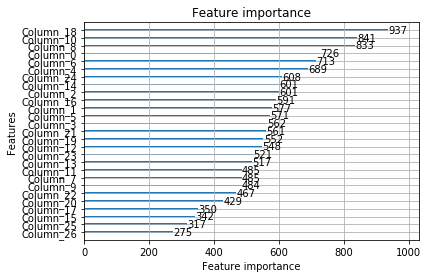

Fold 0 log loss 0.2659167615109141 in 1687
Fold :  1
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.534817	valid_1's multi_logloss: 0.514361
[200]	training's multi_logloss: 0.367754	valid_1's multi_logloss: 0.341498
[300]	training's multi_logloss: 0.30806	valid_1's multi_logloss: 0.28079
[400]	training's multi_logloss: 0.284181	valid_1's multi_logloss: 0.256875
[500]	training's multi_logloss: 0.273674	valid_1's multi_logloss: 0.246564
[600]	training's multi_logloss: 0.268591	valid_1's multi_logloss: 0.241793
[700]	training's multi_logloss: 0.265899	valid_1's multi_logloss: 0.239402
[800]	training's multi_logloss: 0.264345	valid_1's multi_logloss: 0.238145
[900]	training's multi_logloss: 0.26337	valid_1's multi_logloss: 0.237445
[1000]	training's multi_logloss: 0.262728	valid_1's multi_logloss: 0.237037
[1100]	training's multi_logloss: 0.262286	valid_1's multi_logloss: 0.236787
[1200]	training's multi_logloss: 0.261968	valid_1's multi_l

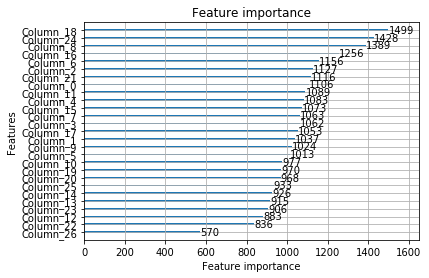

Fold 1 log loss 0.23625467509002543 in 3162
Fold :  2
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.532725	valid_1's multi_logloss: 0.533577
[200]	training's multi_logloss: 0.365179	valid_1's multi_logloss: 0.366053
[300]	training's multi_logloss: 0.305364	valid_1's multi_logloss: 0.305964
[400]	training's multi_logloss: 0.281461	valid_1's multi_logloss: 0.28197
[500]	training's multi_logloss: 0.270989	valid_1's multi_logloss: 0.271342
[600]	training's multi_logloss: 0.265951	valid_1's multi_logloss: 0.266222
[700]	training's multi_logloss: 0.263275	valid_1's multi_logloss: 0.26358
[800]	training's multi_logloss: 0.261728	valid_1's multi_logloss: 0.26216
[900]	training's multi_logloss: 0.260768	valid_1's multi_logloss: 0.261349
[1000]	training's multi_logloss: 0.260129	valid_1's multi_logloss: 0.260865
[1100]	training's multi_logloss: 0.259689	valid_1's multi_logloss: 0.260556
[1200]	training's multi_logloss: 0.259363	valid_1's multi_

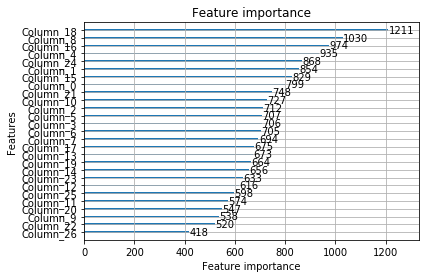

Fold 2 log loss 0.26009641063456906 in 2179
Fold :  3
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.531651	valid_1's multi_logloss: 0.541929
[200]	training's multi_logloss: 0.363791	valid_1's multi_logloss: 0.377743
[300]	training's multi_logloss: 0.303882	valid_1's multi_logloss: 0.319165
[400]	training's multi_logloss: 0.279958	valid_1's multi_logloss: 0.295547
[500]	training's multi_logloss: 0.269476	valid_1's multi_logloss: 0.285049
[600]	training's multi_logloss: 0.264436	valid_1's multi_logloss: 0.27997
[700]	training's multi_logloss: 0.261772	valid_1's multi_logloss: 0.277321
[800]	training's multi_logloss: 0.26023	valid_1's multi_logloss: 0.275868
[900]	training's multi_logloss: 0.259257	valid_1's multi_logloss: 0.275027
[1000]	training's multi_logloss: 0.258619	valid_1's multi_logloss: 0.274555
[1100]	training's multi_logloss: 0.258174	valid_1's multi_logloss: 0.274267
[1200]	training's multi_logloss: 0.257845	valid_1's multi

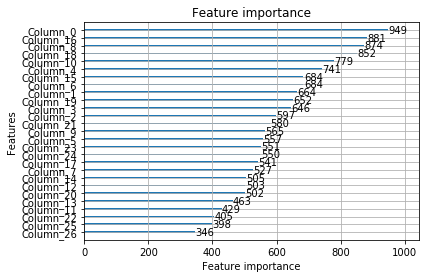

Fold 3 log loss 0.2738766988415174 in 1825
Fold :  4
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.533864	valid_1's multi_logloss: 0.524894
[200]	training's multi_logloss: 0.366582	valid_1's multi_logloss: 0.354437
[300]	training's multi_logloss: 0.306791	valid_1's multi_logloss: 0.293454
[400]	training's multi_logloss: 0.282878	valid_1's multi_logloss: 0.269189
[500]	training's multi_logloss: 0.272373	valid_1's multi_logloss: 0.258771
[600]	training's multi_logloss: 0.26731	valid_1's multi_logloss: 0.253796
[700]	training's multi_logloss: 0.264623	valid_1's multi_logloss: 0.251249
[800]	training's multi_logloss: 0.263068	valid_1's multi_logloss: 0.249831
[900]	training's multi_logloss: 0.262096	valid_1's multi_logloss: 0.249038
[1000]	training's multi_logloss: 0.26145	valid_1's multi_logloss: 0.248594
[1100]	training's multi_logloss: 0.260996	valid_1's multi_logloss: 0.248331
[1200]	training's multi_logloss: 0.260661	valid_1's multi_

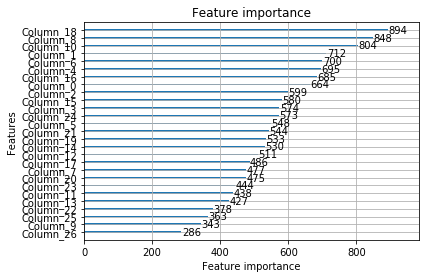

Fold 4 log loss 0.24803842380021507 in 1679
Fold :  5
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.531912	valid_1's multi_logloss: 0.539614
[200]	training's multi_logloss: 0.364194	valid_1's multi_logloss: 0.373995
[300]	training's multi_logloss: 0.304347	valid_1's multi_logloss: 0.314496
[400]	training's multi_logloss: 0.280445	valid_1's multi_logloss: 0.290781
[500]	training's multi_logloss: 0.269958	valid_1's multi_logloss: 0.280429
[600]	training's multi_logloss: 0.264894	valid_1's multi_logloss: 0.275468
[700]	training's multi_logloss: 0.26222	valid_1's multi_logloss: 0.272902
[800]	training's multi_logloss: 0.260664	valid_1's multi_logloss: 0.271485
[900]	training's multi_logloss: 0.259685	valid_1's multi_logloss: 0.270685
[1000]	training's multi_logloss: 0.259046	valid_1's multi_logloss: 0.270217
[1100]	training's multi_logloss: 0.258604	valid_1's multi_logloss: 0.26993
[1200]	training's multi_logloss: 0.258283	valid_1's multi

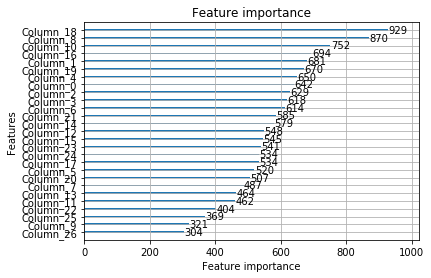

Fold 5 log loss 0.2695882132699292 in 1717
Fold :  6
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.530226	valid_1's multi_logloss: 0.550842
[200]	training's multi_logloss: 0.362098	valid_1's multi_logloss: 0.390075
[300]	training's multi_logloss: 0.302173	valid_1's multi_logloss: 0.333357
[400]	training's multi_logloss: 0.278272	valid_1's multi_logloss: 0.310659
[500]	training's multi_logloss: 0.267807	valid_1's multi_logloss: 0.300548
[600]	training's multi_logloss: 0.262775	valid_1's multi_logloss: 0.295699
[700]	training's multi_logloss: 0.26013	valid_1's multi_logloss: 0.293153
[800]	training's multi_logloss: 0.258601	valid_1's multi_logloss: 0.29169
[900]	training's multi_logloss: 0.257644	valid_1's multi_logloss: 0.29082
[1000]	training's multi_logloss: 0.25702	valid_1's multi_logloss: 0.29033
[1100]	training's multi_logloss: 0.256595	valid_1's multi_logloss: 0.290062
[1200]	training's multi_logloss: 0.256283	valid_1's multi_log

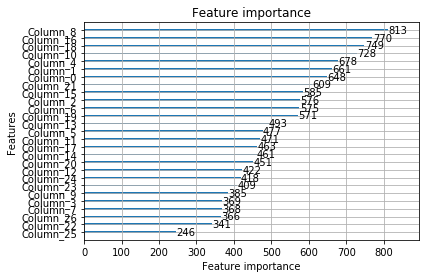

Fold 6 log loss 0.2897184396785745 in 1567
Fold :  7
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.532558	valid_1's multi_logloss: 0.534694
[200]	training's multi_logloss: 0.364969	valid_1's multi_logloss: 0.36733
[300]	training's multi_logloss: 0.305166	valid_1's multi_logloss: 0.307291
[400]	training's multi_logloss: 0.281278	valid_1's multi_logloss: 0.283316
[500]	training's multi_logloss: 0.270792	valid_1's multi_logloss: 0.272764
[600]	training's multi_logloss: 0.26574	valid_1's multi_logloss: 0.26774
[700]	training's multi_logloss: 0.263057	valid_1's multi_logloss: 0.265187
[800]	training's multi_logloss: 0.261496	valid_1's multi_logloss: 0.263822
[900]	training's multi_logloss: 0.260529	valid_1's multi_logloss: 0.263065
[1000]	training's multi_logloss: 0.259898	valid_1's multi_logloss: 0.262651
[1100]	training's multi_logloss: 0.25946	valid_1's multi_logloss: 0.262396
[1200]	training's multi_logloss: 0.259142	valid_1's multi_lo

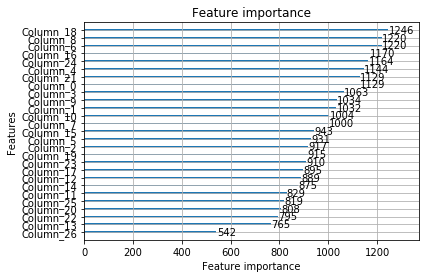

Fold 7 log loss 0.26207906849272916 in 2932
Fold :  8
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.532684	valid_1's multi_logloss: 0.534602
[200]	training's multi_logloss: 0.365127	valid_1's multi_logloss: 0.367013
[300]	training's multi_logloss: 0.305249	valid_1's multi_logloss: 0.306962
[400]	training's multi_logloss: 0.281322	valid_1's multi_logloss: 0.283016
[500]	training's multi_logloss: 0.270818	valid_1's multi_logloss: 0.272704
[600]	training's multi_logloss: 0.265755	valid_1's multi_logloss: 0.267835
[700]	training's multi_logloss: 0.263083	valid_1's multi_logloss: 0.265346
[800]	training's multi_logloss: 0.261553	valid_1's multi_logloss: 0.263989
[900]	training's multi_logloss: 0.260594	valid_1's multi_logloss: 0.263228
[1000]	training's multi_logloss: 0.259971	valid_1's multi_logloss: 0.262784
[1100]	training's multi_logloss: 0.259532	valid_1's multi_logloss: 0.262532
[1200]	training's multi_logloss: 0.259214	valid_1's mul

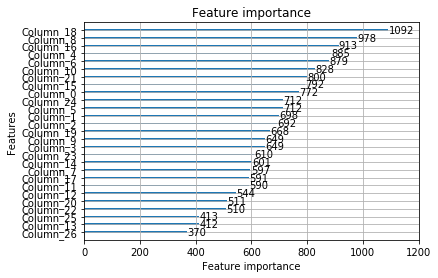

Fold 8 log loss 0.26213798042870184 in 2052
Fold :  9
Training until validation scores don't improve for 1000 rounds.
[100]	training's multi_logloss: 0.533528	valid_1's multi_logloss: 0.524432
[200]	training's multi_logloss: 0.366241	valid_1's multi_logloss: 0.354908
[300]	training's multi_logloss: 0.306492	valid_1's multi_logloss: 0.295015
[400]	training's multi_logloss: 0.282572	valid_1's multi_logloss: 0.271461
[500]	training's multi_logloss: 0.272067	valid_1's multi_logloss: 0.261301
[600]	training's multi_logloss: 0.266987	valid_1's multi_logloss: 0.256631
[700]	training's multi_logloss: 0.264299	valid_1's multi_logloss: 0.25433
[800]	training's multi_logloss: 0.262733	valid_1's multi_logloss: 0.253106
[900]	training's multi_logloss: 0.261748	valid_1's multi_logloss: 0.252413
[1000]	training's multi_logloss: 0.261101	valid_1's multi_logloss: 0.252017
[1100]	training's multi_logloss: 0.260661	valid_1's multi_logloss: 0.251786
[1200]	training's multi_logloss: 0.260332	valid_1's mult

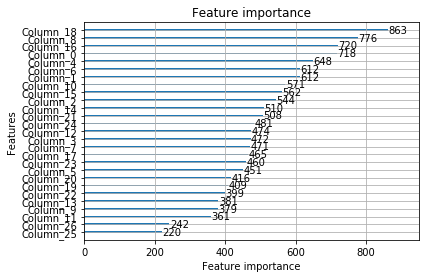

Fold 9 log loss 0.2515086020611269 in 1525
Training  Finish


In [39]:
pred, log_loss, oofs = fit_every_feature_model(ensemble_trains, labels, ensemble_tests, fold_count=10)

In [40]:
log_loss

0.2619215273808303

In [41]:
oofs = np.concatenate(oofs)
oofs.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [42]:
def np_weighted_accuracy(y_true, y_pred):
    weight = np.array([[1/16, 1/15, 1/5]])
    norm = [(1/16) + (1/15) + (1/5)]
    weight_mask = weight * y_true
    weight_mask = np.max(weight_mask, axis=-1)
    norms = np.sum(weight_mask)
    
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)
    
    res = ((y_true == y_pred) * weight_mask).sum() / norms
    return res

In [1]:
score = np_weighted_accuracy(to_categorical(labels), oofs)

NameError: name 'np_weighted_accuracy' is not defined

In [53]:
print("score", score)
oofs_dir = "../data/ensemble/oofs/"
output_dir = "../data/ensemble/pred/"
onehot_pred_dir = "../data/ensemble/nn_one_hot/"

model_submit_prefix = "LightGBM-Ensemble"

oofs_path = oofs_dir + model_submit_prefix
output_path = output_dir + model_submit_prefix
one_hot_pred_path = onehot_pred_dir + "One-Hot" + model_submit_prefix

print("Predicting training results...")
oofs = pd.DataFrame({"unrelated": oofs[:, 0], "agreed": oofs[:, 1], "disagreed": oofs[:, 2]})
submit_path = oofs_path + "-Train-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
oofs.to_csv(submit_path, index=False)

test_predicts = pd.DataFrame({"unrelated": pred[:, 0], "agreed": pred[:, 1], "disagreed": pred[:, 2]})
submit_path = output_path + "-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
test_predicts.to_csv(submit_path, index=False) # 0.3343

print("Predicting labeled testing results...")
ids = pd.read_csv("../data/dataset/test.csv")
pred_labels = test_predicts.idxmax(axis=1)
sub = pd.DataFrame({"Id": ids['id'].values, "Category": pred_labels})
submit_path = one_hot_pred_path + "-L{:4f}-NB{:d}.csv".format(score, NB_WORDS)
sub.to_csv(submit_path, index=False)

score 0.8601171890929914
Predicting training results...


TypeError: unhashable type: 'slice'